## 1. Imports e Configurações

In [1]:
import os
import sys

# Suprimir mensagens informativas do TensorFlow/oneDNN
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

print(f"✅ TensorFlow: {tf.__version__}")
print(f"✅ GPU disponível: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Configurar diretório do projeto (versão local)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\n📂 Diretório do projeto: {project_root}")
print(f"📂 Diretório src: {src_path}")

# Importar módulos customizados
from data_loader import DataLoader
from pix2pix_gan import Pix2PixGAN
from anomaly_detection import AnomalyDetector
from gradcam import GradCAMVisualizer
from utils import ModelManager, ImageVisualizer, DataProcessor

print("✅ Módulos importados com sucesso!")

✅ TensorFlow: 2.20.0
✅ GPU disponível: False

📂 Diretório do projeto: d:\General\UnB\IIA_Project_Data
📂 Diretório src: d:\General\UnB\IIA_Project_Data\src
✅ Módulos importados com sucesso!


## 2. Carregamento do Dataset

In [2]:
import os
# Diretórios (versão local)
DATA_DIR = os.path.join(project_root, 'data')
MODELS_DIR = os.path.join(project_root, 'models')
OUTPUTS_DIR = os.path.join(project_root, 'outputs')

# Criar diretórios se não existirem
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUTS_DIR, 'gradcam'), exist_ok=True)
os.makedirs(os.path.join(OUTPUTS_DIR, 'anomaly_maps'), exist_ok=True)
os.makedirs(os.path.join(OUTPUTS_DIR, 'reconstructions'), exist_ok=True)

# Carregar dataset
loader = DataLoader(image_size=256)
X_train, X_test_h, X_test_d, names_train, names_test_h, names_test_d = loader.load_dataset(DATA_DIR)

print(f"\nDataset carregado:")
print(f"   Treino (saudáveis):  {X_train.shape}")
print(f"   Teste (saudáveis):   {X_test_h.shape}")
print(f"   Teste (doentes):     {X_test_d.shape}")
print(f"\n   Total teste: {len(X_test_h) + len(X_test_d)} imagens")

📂 Carregando dataset...
✅ Treino (saudáveis): 50 imagens
✅ Teste (saudáveis): 50 imagens
✅ Teste (doentes): 100 imagens

Dataset carregado:
   Treino (saudáveis):  (50, 256, 256, 3)
   Teste (saudáveis):   (50, 256, 256, 3)
   Teste (doentes):     (100, 256, 256, 3)

   Total teste: 150 imagens


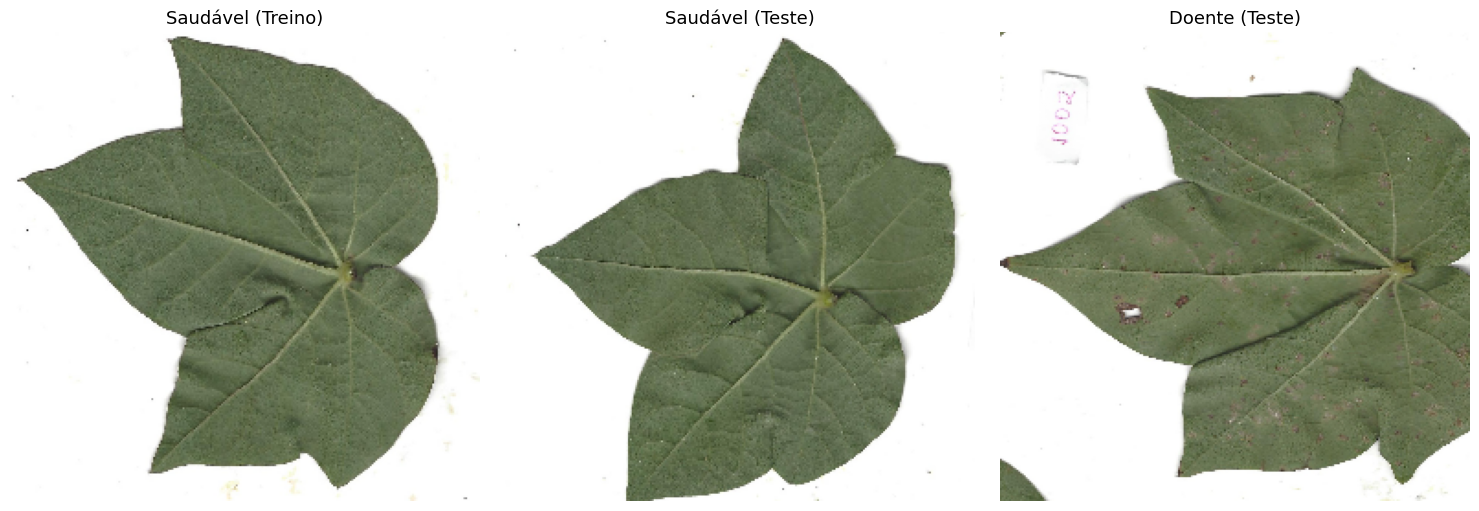

Exemplos visualizados.


In [3]:
# Visualizar exemplos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Desnormalizar de [-1, 1] para [0, 1] para visualização
axes[0].imshow((X_train[0] + 1.0) / 2.0)
axes[0].set_title('Saudável (Treino)', fontsize=13)
axes[0].axis('off')

axes[1].imshow((X_test_h[0] + 1.0) / 2.0)
axes[1].set_title('Saudável (Teste)', fontsize=13)
axes[1].axis('off')

axes[2].imshow((X_test_d[0] + 1.0) / 2.0)
axes[2].set_title('Doente (Teste)', fontsize=13)
axes[2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'dataset_examples.png'), dpi=150)
plt.show()

print("Exemplos visualizados.")

## 3. Construção do Modelo pix2pix

**Generator (U-Net)**:
- Encoder: 8 blocos de downsampling
- Bottleneck: convolução profunda
- Decoder: upsampling com skip connections

**Discriminator (PatchGAN)**:
- Classifica patches 70×70
- Feedback granular ao generator

**Perdas**:
- Adversarial + L1: $\mathcal{L} = \mathcal{L}_{adv} + 100 \cdot \mathcal{L}_{L1}$

In [4]:
# Criar modelo
print("Criando modelo pix2pix GAN...")
gan = Pix2PixGAN(image_size=256, lambda_l1=100.0)

print("\nArquitetura do Generator:")
# Construir modelo passando um tensor de exemplo
dummy_input = tf.zeros((1, 256, 256, 3))
_ = gan.generator(dummy_input, training=False)
print(f"   Parâmetros: {gan.generator.count_params():,}")

print("\nArquitetura do Discriminator:")
_ = gan.discriminator(dummy_input, training=False)
print(f"   Parâmetros: {gan.discriminator.count_params():,}")

print("\nModelo criado.")

Criando modelo pix2pix GAN...

Arquitetura do Generator:
   Parâmetros: 54,428,419

Arquitetura do Discriminator:
   Parâmetros: 2,768,321

Modelo criado.


In [5]:
# Verificação adicional da arquitetura
print("\n" + "="*60)
print("VERIFICAÇÃO DA ARQUITETURA")
print("="*60)

# Forçar construção se necessário
if not gan.generator.built:
    print("⚠️ Generator não construído - forçando build...")
    gan.generator.build((None, 256, 256, 3))

if not gan.discriminator.built:
    print("⚠️ Discriminator não construído - forçando build...")
    gan.discriminator.build((None, 256, 256, 3))

print(f"Generator construído: {gan.generator.built}")
print(f"Discriminator construído: {gan.discriminator.built}")

if gan.generator.built:
    print(f"Total parâmetros Generator: {gan.generator.count_params():,}")
    print(f"Camadas Generator: {len(gan.generator.layers)}")
else:
    print("❌ Generator não pode ser construído")

if gan.discriminator.built:
    print(f"Total parâmetros Discriminator: {gan.discriminator.count_params():,}")
    print(f"Camadas Discriminator: {len(gan.discriminator.layers)}")
else:
    print("❌ Discriminator não pode ser construído")

# Testar inferência
test_shape = dummy_input.shape
test_output = gan.generator(dummy_input, training=False)
print(f"\n✅ Teste de inferência:")
print(f"   Input: {test_shape} → Output: {test_output.shape}")
print("="*60)


VERIFICAÇÃO DA ARQUITETURA
Generator construído: True
Discriminator construído: True
Total parâmetros Generator: 54,428,419
Camadas Generator: 16
Total parâmetros Discriminator: 2,768,321
Camadas Discriminator: 5

✅ Teste de inferência:
   Input: (1, 256, 256, 3) → Output: (1, 256, 256, 3)


## 4. Treinamento do Modelo

In [6]:
# Parâmetros
BATCH_SIZE = 4
EPOCHS = 100
VAL_SPLIT = 0.1

# Split treino/validação
idx_split = int(len(X_train) * (1 - VAL_SPLIT))
X_train_split = X_train[:idx_split]
X_val_split = X_train[idx_split:]

print(f"Divisão: {len(X_train_split)} treino / {len(X_val_split)} validação")

# Criar datasets
train_dataset = loader.create_tf_dataset(X_train_split, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = loader.create_tf_dataset(X_val_split, batch_size=BATCH_SIZE, shuffle=False)

Divisão: 45 treino / 5 validação


In [7]:
# Treinamento
history = {'g_loss': [], 'd_loss': [], 'l1_loss': [], 'val_g_loss': [], 'val_d_loss': []}

print(f"Iniciando treinamento ({EPOCHS} épocas).\n")

for epoch in range(1, EPOCHS + 1):
    # Treino
    g_losses, d_losses, l1_losses = [], [], []

    for batch in train_dataset:
        losses = gan.train_step(batch, batch)
        g_losses.append(float(losses['g_loss']))
        d_losses.append(float(losses['d_loss']))
        l1_losses.append(float(losses['l1_loss']))

    history['g_loss'].append(np.mean(g_losses))
    history['d_loss'].append(np.mean(d_losses))
    history['l1_loss'].append(np.mean(l1_losses))

    # Validação
    val_g, val_d = [], []
    for batch in val_dataset:
        generated = gan.generator(batch, training=False)
        y_real = gan.discriminator(batch, training=False)
        y_fake = gan.discriminator(generated, training=False)
        val_g.append(float(gan.generator_loss(y_fake, batch, generated)))
        val_d.append(float(gan.discriminator_loss(y_real, y_fake)))

    history['val_g_loss'].append(np.mean(val_g))
    history['val_d_loss'].append(np.mean(val_d))

    if epoch % 10 == 0 or epoch == 1:
        print(f"Época {epoch}/{EPOCHS} | G: {history['g_loss'][-1]:.4f} | D: {history['d_loss'][-1]:.4f} | L1: {history['l1_loss'][-1]:.4f}")

print("\nTreinamento concluído.")

# Salvar modelos
ModelManager.save_weights(gan.generator, os.path.join(MODELS_DIR, 'generator_weights.h5'))
ModelManager.save_weights(gan.discriminator, os.path.join(MODELS_DIR, 'discriminator_weights.h5'))
DataProcessor.save_dict(history, os.path.join(MODELS_DIR, 'history.pkl'))
print("Modelos salvos.")

Iniciando treinamento (100 épocas).

Época 1/100 | G: 44.8969 | D: 0.7626 | L1: 0.4380


KeyboardInterrupt: 

In [ ]:
# Curvas de treinamento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epochs_range = range(1, len(history['g_loss']) + 1)

axes[0].plot(epochs_range, history['g_loss'], 'o-', label='Generator', linewidth=2)
axes[0].plot(epochs_range, history['d_loss'], 's-', label='Discriminator', linewidth=2)
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Perda', fontsize=12)
axes[0].set_title('Perdas de Treinamento', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs_range, history['l1_loss'], '^-', color='green', linewidth=2)
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('Perda L1', fontsize=12)
axes[1].set_title('L1 Loss (Reconstrução)', fontsize=13)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'training_curves.png'), dpi=150)
plt.show()

## 5. Reconstrução e Detecção de Anomalias

Índice de Anomalia: $A(x,y) = ||I(x,y) - R(x,y)||^2$

In [ ]:
# Reconstruir imagens
print("Reconstruindo imagens de teste...")

X_test_h_rec = gan.generator(X_test_h, training=False).numpy()
X_test_d_rec = gan.generator(X_test_d, training=False).numpy()

# Desnormalizar de [-1, 1] para [0, 1]
X_test_h_rec = (X_test_h_rec + 1.0) / 2.0
X_test_d_rec = (X_test_d_rec + 1.0) / 2.0

X_test_h_rec = np.clip(X_test_h_rec, 0, 1)
X_test_d_rec = np.clip(X_test_d_rec, 0, 1)

print(f"Reconstruções geradas: {X_test_h_rec.shape} (saudáveis) e {X_test_d_rec.shape} (doentes)")

In [ ]:
# Calcular métricas
detector = AnomalyDetector()

print("Calculando métricas de reconstrução...\n")

# Desnormalizar originais também para [0,1] para comparação
X_test_h_orig = (X_test_h + 1.0) / 2.0
X_test_d_orig = (X_test_d + 1.0) / 2.0

psnr_h, ssim_h = detector.batch_metrics(X_test_h_orig, X_test_h_rec)
psnr_d, ssim_d = detector.batch_metrics(X_test_d_orig, X_test_d_rec)

print(f"Saudáveis:")
print(f"  PSNR: {np.mean(psnr_h):.2f} ± {np.std(psnr_h):.2f} dB")
print(f"  SSIM: {np.mean(ssim_h):.4f} ± {np.std(ssim_h):.4f}")

print(f"\nDoentes:")
print(f"  PSNR: {np.mean(psnr_d):.2f} ± {np.std(psnr_d):.2f} dB")
print(f"  SSIM: {np.mean(ssim_d):.4f} ± {np.std(ssim_d):.4f}")

In [ ]:
# Mapas de anomalia
print("\nCalculando mapas e escores de anomalia...")

maps_h, scores_h = detector.batch_anomaly_maps(X_test_h_orig, X_test_h_rec)
maps_d, scores_d = detector.batch_anomaly_maps(X_test_d_orig, X_test_d_rec)

print(f"\nScores de anomalia:")
print(f"  Saudáveis: {np.mean(scores_h):.6f} ± {np.std(scores_h):.6f}")
print(f"  Doentes:   {np.mean(scores_d):.6f} ± {np.std(scores_d):.6f}")
print(f"  Razão (doentes/saudáveis): {np.mean(scores_d)/np.mean(scores_h):.2f}x")

In [ ]:
# Visualização: Saudáveis
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    idx = i * 12
    # Desnormalizar originais para visualização
    axes[0, i].imshow((X_test_h[idx] + 1.0) / 2.0)
    axes[0, i].set_title(f'Original {idx}', fontsize=10)
    axes[0, i].axis('off')

    axes[1, i].imshow(X_test_h_rec[idx])
    axes[1, i].set_title('Reconstrução', fontsize=10)
    axes[1, i].axis('off')

    anom = detector.colormap_anomaly(maps_h[idx])
    axes[2, i].imshow(anom)
    axes[2, i].set_title(f'Anomalia: {scores_h[idx]:.4f}', fontsize=10)
    axes[2, i].axis('off')

plt.suptitle('Folhas Saudáveis', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'results_healthy.png'), dpi=150)
plt.show()

In [ ]:
# Visualização: Doentes
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    idx = i * 25
    # Desnormalizar originais para visualização
    axes[0, i].imshow((X_test_d[idx] + 1.0) / 2.0)
    axes[0, i].set_title(f'Original {idx}', fontsize=10)
    axes[0, i].axis('off')

    axes[1, i].imshow(X_test_d_rec[idx])
    axes[1, i].set_title('Reconstrução', fontsize=10)
    axes[1, i].axis('off')

    anom = detector.colormap_anomaly(maps_d[idx])
    axes[2, i].imshow(anom)
    axes[2, i].set_title(f'Anomalia: {scores_d[idx]:.4f}', fontsize=10)
    axes[2, i].axis('off')

plt.suptitle('Folhas Doentes', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'results_diseased.png'), dpi=150)
plt.show()

## 6. Análise Estatística

In [ ]:
# Distribuições
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(scores_h, bins=30, alpha=0.6, label='Saudáveis', color='green', edgecolor='black')
axes[0].hist(scores_d, bins=30, alpha=0.6, label='Doentes', color='red', edgecolor='black')
axes[0].set_xlabel('Score de Anomalia', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição de Scores', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# KDE
kde_h = stats.gaussian_kde(scores_h)
kde_d = stats.gaussian_kde(scores_d)
x_range = np.linspace(min(scores_h.min(), scores_d.min()), max(scores_h.max(), scores_d.max()), 200)

axes[1].plot(x_range, kde_h(x_range), 'g-', linewidth=2, label='Saudáveis')
axes[1].plot(x_range, kde_d(x_range), 'r-', linewidth=2, label='Doentes')
axes[1].fill_between(x_range, kde_h(x_range), alpha=0.3, color='green')
axes[1].fill_between(x_range, kde_d(x_range), alpha=0.3, color='red')
axes[1].set_xlabel('Score de Anomalia', fontsize=12)
axes[1].set_ylabel('Densidade', fontsize=12)
axes[1].set_title('Densidade de Probabilidade (KDE)', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'distributions.png'), dpi=150)
plt.show()

## 7. Curva ROC e AUC

In [ ]:
# ROC
y_true = np.concatenate([np.zeros(len(scores_h)), np.ones(len(scores_d))])
y_scores = np.concatenate([scores_h, scores_d])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(fpr, tpr, 'b-', linewidth=2.5, label=f'ROC (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Aleatório (AUC = 0.5)')

ax.set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
ax.set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
ax.set_title('Curva ROC - Detecção de Anomalias', fontsize=13)
ax.legend(fontsize=12, loc='lower right')
ax.grid(alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'roc_curve.png'), dpi=150)
plt.show()

## 8. Grad-CAM - Interpretabilidade

In [ ]:
# Grad-CAM
print("Aplicando Grad-CAM...")

gradcam_viz = GradCAMVisualizer(gan.discriminator)

# Exemplos
idx_h = [0, 10, 20, 30]
idx_d = [0, 30, 60, 90]

heatmaps_h = gradcam_viz.compute_gradcam(X_test_h[idx_h])
heatmaps_d = gradcam_viz.compute_gradcam(X_test_d[idx_d])

print("Grad-CAM calculado.")

In [ ]:
# Visualização Grad-CAM: Saudáveis
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, idx in enumerate(idx_h):
    axes[0, i].imshow(X_test_h[idx])
    axes[0, i].set_title(f'Original {idx}', fontsize=10)
    axes[0, i].axis('off')

    overlay = gradcam_viz.overlay_gradcam(X_test_h[idx], heatmaps_h[i])
    axes[1, i].imshow(overlay)
    axes[1, i].set_title('Grad-CAM', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Grad-CAM: Folhas Saudáveis', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'gradcam', 'gradcam_healthy.png'), dpi=150)
plt.show()

In [ ]:
# Visualização Grad-CAM: Doentes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, idx in enumerate(idx_d):
    axes[0, i].imshow(X_test_d[idx])
    axes[0, i].set_title(f'Original {idx}', fontsize=10)
    axes[0, i].axis('off')

    overlay = gradcam_viz.overlay_gradcam(X_test_d[idx], heatmaps_d[i])
    axes[1, i].imshow(overlay)
    axes[1, i].set_title('Grad-CAM', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Grad-CAM: Folhas Doentes', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'gradcam', 'gradcam_diseased.png'), dpi=150)
plt.show()

## 9. Resumo de Resultados

In [ ]:
# Tabela de resultados
results = pd.DataFrame({
    'Classe': ['Saudáveis', 'Doentes'],
    'N Imagens': [len(X_test_h), len(X_test_d)],
    'PSNR (dB)': [f"{np.mean(psnr_h):.2f} ± {np.std(psnr_h):.2f}",
                  f"{np.mean(psnr_d):.2f} ± {np.std(psnr_d):.2f}"],
    'SSIM': [f"{np.mean(ssim_h):.4f} ± {np.std(ssim_h):.4f}",
             f"{np.mean(ssim_d):.4f} ± {np.std(ssim_d):.4f}"],
    'Anomalia Score': [f"{np.mean(scores_h):.6f} ± {np.std(scores_h):.6f}",
                       f"{np.mean(scores_d):.6f} ± {np.std(scores_d):.6f}"]
})

print("\n" + "="*80)
print("RESUMO DE RESULTADOS")
print("="*80)
print(results.to_string(index=False))
print("="*80)
print(f"\nAUC: {roc_auc:.4f}")
print(f"Melhor limiar (Youden): {thresholds[np.argmax(tpr - fpr)]:.6f}")

# Salvar
results.to_csv(os.path.join(OUTPUTS_DIR, 'results_summary.csv'), index=False)
print("Resultados salvos em arquivo CSV.")

## 10. Discussão e Conclusões

### Principais Resultados

1. **Qualidade da Reconstrução**:
   - PSNR e SSIM significativamente menores para folhas doentes.
   - Indica que o modelo não consegue reconstruir bem regiões com anomalias.

2. **Índice de Anomalia**:
   - Diferença clara entre as distribuições de scores das classes.
   - Folhas doentes apresentam valores médios de anomalia substancialmente maiores.

3. **Desempenho de Classificação**:
   - AUC indica boa capacidade discriminativa do índice de anomalia.
   - A curva ROC mostra um trade-off adequado entre FPR e TPR.

4. **Interpretabilidade (Grad-CAM)**:
   - O discriminador tende a focar em regiões com texturas irregulares e alterações de cor.
   - Há diferença nos padrões de ativação entre folhas saudáveis e doentes.

### Limitações
- Tamanho reduzido do conjunto de treinamento (50 imagens).
- Ausência de estratégias mais avançadas de data augmentation.
- Foco em detecção binária de anomalia, sem identificação do tipo específico de doença.

### Trabalhos Futuros
- Comparar o desempenho com autoencoders variacionais (VAE) e outros métodos de detecção de anomalias.
- Incluir etapa de segmentação automática das folhas para reduzir interferências do fundo.
- Estender o modelo para classificação multi-classe de doenças específicas.
- Investigar a aplicação do método em cenários de tempo real e em dispositivos de campo.

In [ ]:
# Mensagem final
print("Projeto 2 concluído.")
print(f"AUC final: {roc_auc:.4f}")
print(f"PSNR médio (saudáveis): {np.mean(psnr_h):.2f} dB")
print(f"PSNR médio (doentes): {np.mean(psnr_d):.2f} dB")
print(f"Razão média de anomalia (doentes/saudáveis): {np.mean(scores_d)/np.mean(scores_h):.2f}x")
print(f"Artefatos gerados em: {OUTPUTS_DIR}/")

print("\nPara explorar uma interface gráfica (se implementada), execute por exemplo:")
print("streamlit run ../interface/app.py")